In [1]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, SpatialDropout1D, BatchNormalization

In [34]:
movie=pd.read_csv('CleanedMovies.csv')
#converting string into list object
movie['review']=movie['review'].apply(ast.literal_eval)

In [35]:
movie['review']=movie['review'].apply(lambda x : ' '.join(x))
movie

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment side maltin...,0


In [36]:
#choosing train-test split as 0.2, randomState as 2023, and choosing validation set from train set
label=movie['sentiment']
x_train, x_test, y_train, y_test = train_test_split(
    movie['review'], label, test_size=0.2, random_state=2023)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=2023)


In [37]:
#defining the parameters before tokenizing
lDim = 200
trunc = 'post'
padder = 'post'
not_inDic = '<OOV>' 
maxVoc = 8000
eDim = 150

In [38]:
#tokenizer initiated with the above parameters and fitted on training data
tokenizer = Tokenizer(num_words = maxVoc, 
                      char_level = False,
                      oov_token = not_inDic)
tokenizer.fit_on_texts(x_train)

In [39]:
word_index = tokenizer.word_index
total_words = len(set(word_index))
total_words


170350

In [40]:
#converting the text data into sequences of numbers
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = lDim,
                                padding = padder,
                                truncating = trunc)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = lDim,
                               padding = padder,
                               truncating = trunc)
val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, 
                           maxlen=lDim, 
                           padding=padder, 
                           truncating=trunc)

In [41]:
#defining the model
model = Sequential()
model.add(Embedding(maxVoc, eDim,))
model.add(SpatialDropout1D(0.2))
model.add(GRU(95, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(22,activation='relu'))
model.add(Dense(11,activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [42]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
#The initial learning rate is set to 0.0015, and it decays exponentially with a decay rate of 0.9 every 1000 steps
initial_learning_rate = 0.0015
ilr_opte = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=False)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ilr_opte), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
num_epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
history = model.fit(training_padded,
                     y_train,
                     epochs=num_epochs, 
                     validation_data=(val_padded,y_val),
                     callbacks =[early_stop],
                     batch_size=60,
                     verbose=1)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5054 - loss: 0.6921 - val_accuracy: 0.7903 - val_loss: 0.4808
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.8389 - loss: 0.3821 - val_accuracy: 0.8963 - val_loss: 0.2485
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9316 - loss: 0.1885 - val_accuracy: 0.8888 - val_loss: 0.2833
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - accuracy: 0.9617 - loss: 0.1191 - val_accuracy: 0.8850 - val_loss: 0.3280


In [44]:
from sklearn.metrics import accuracy_score
prediction = model.predict(testing_padded)
pred_labels = []
# converting the predicted probabilities into binary labels based on a threshold of 0.5
for i in prediction:
    if i > 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,pred_labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Accuracy of prediction on test set :  0.8922


In [45]:
model.save('models/GRU/GRU.keras')
model.save_weights('models/GRU/GRU.weights.h5')

In [2]:
model=keras.saving.load_model('models/GRU/GRU.keras')
model.summary()
print(model.count_params())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (60, 200, 150)         │     1,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (60, 200, 150)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (60, 95)               │        70,395 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (60, 95)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (60, 22)               │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (60, 11)               │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (60, 1)                │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,818,317 (14.57 MB)

 Trainable params: 1,272,772 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,545,545 (9.71 MB)

1272772


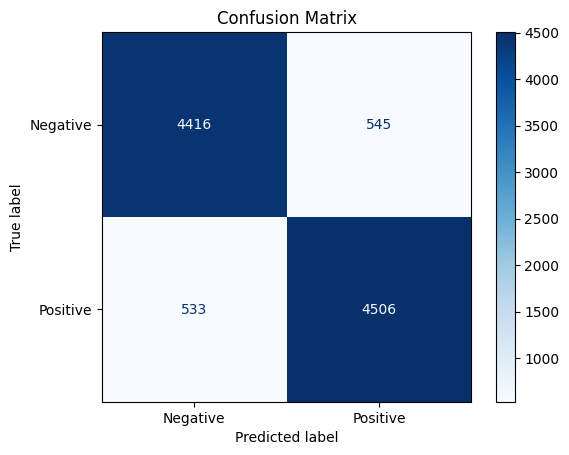

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_labels)
labels = ['Negative', 'Positive']
# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

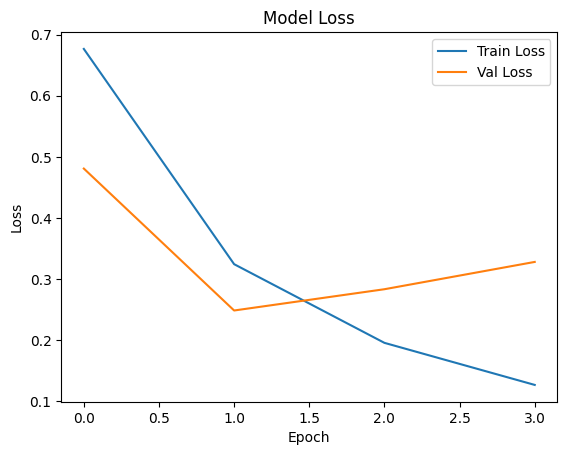

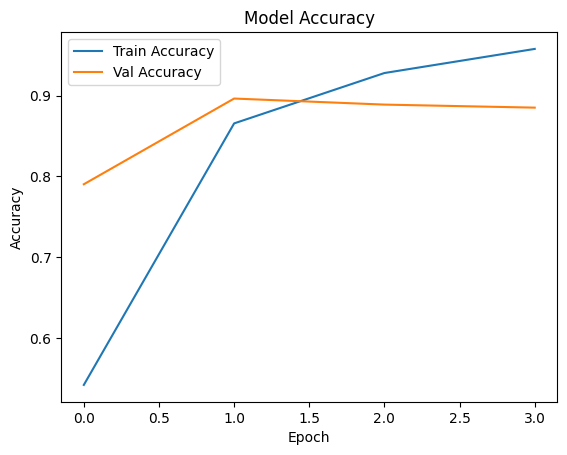

In [48]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()